In [43]:
#Importing all the libraries
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from itertools import chain
from scipy import stats

from scipy.stats import f_oneway
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor

import xgboost
from xgboost import XGBRegressor

import torch
import torch.nn as nn
import os
from os import path
from sklearn.metrics import mean_squared_error
from captum.attr import IntegratedGradients, DeepLift, GradientShap, NoiseTunnel, FeatureAblation

In [2]:
def splitting_data(X, y):
    column_names = list(X.columns)
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state=3)
    train_X, valid_X, train_y, valid_y = train_test_split(train_X, train_y, test_size = 0.25, random_state=3)
    return train_X, valid_X, test_X, train_y, test_y, valid_y, column_names


def scale_data(scalar, train_X, valid_X, test_X, column_names):
    scaler = scalar.fit(train_X)
    train_X = scaler.transform(train_X)
    valid_X = scaler.transform(valid_X)
    test_X = scaler.transform(test_X)

    train_X = pd.DataFrame(train_X)
    train_X.columns = column_names

    valid_X = pd.DataFrame(valid_X)
    valid_X.columns = column_names

    test_X = pd.DataFrame(test_X)
    test_X.columns = column_names

    return train_X, valid_X, test_X



In [3]:
df_numeric = pd.read_csv('XAI_data.csv')

In [4]:
non_binary = df_numeric.loc[:, df_numeric.apply(lambda x: x.nunique()) >= 3]

In [5]:
#We make a dataframe with only the non binary columns
df_outlier_removal = df_numeric[list(non_binary.columns)]

#The rows with an outlier in any of the columns get removed based on the z-score
df_outlier_removal = df_outlier_removal[(np.abs(stats.zscore(df_outlier_removal)) < 3).all(axis=1)]

In [6]:
df_binary = df_numeric.drop(columns=list(df_outlier_removal.columns))


In [7]:
#The final dataframe gets created based on the merge of the non-binary and the binary dataframes. 
#We make sure that only the rows that match index will be put in the dataframe so that only the rows
#without an outlier stay in the dataset
df_outlier = df_outlier_removal.merge(df_binary, left_index=True, right_index=True, how='inner')

In [8]:
df_outlier = df_outlier.reset_index(drop=True)


In [9]:
#An x and y get created baesd on the outlier data
X_outlier = df_outlier.drop(columns='Laatste vraagprijs')
y_outlier = df_outlier['Laatste vraagprijs']

In [10]:
X_outlier.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8047 entries, 0 to 8046
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Aantal kamers             8047 non-null   int64  
 1   Perceel m2                8047 non-null   int64  
 2   Achtertuin m2             8047 non-null   int64  
 3   Inhoud in m3              8047 non-null   int64  
 4   Aantal slaapkamers        8047 non-null   int64  
 5   Bathrooms                 8047 non-null   int64  
 6   Toilets                   8047 non-null   int64  
 7   Woonlagen                 8047 non-null   int64  
 8   Bergruimte                8047 non-null   int64  
 9   Sum_Soort garage          8047 non-null   int64  
 10  Sum_Balkon/dakterras      8047 non-null   int64  
 11  Sum_Tuin                  8047 non-null   int64  
 12  Sum_Voorzieningen         8047 non-null   int64  
 13  Sum_Isolatie              8047 non-null   int64  
 14  Sum_Verw

In [11]:
train_X, valid_X, test_X, train_y, test_y, valid_y, column_names = splitting_data(X_outlier, y_outlier)

train_X, valid_X, test_X = scale_data(scalar=StandardScaler(), train_X=train_X, valid_X=valid_X, test_X=test_X, column_names=column_names)
model = XGBRegressor(n_estimators=80, max_depth=5, eta=0.1, silent=True)
model.fit(train_X, train_y)


c:\Users\HUAWEI\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:20:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=80,
             n_jobs=None, num_parallel_tree=None, ...)

In [12]:
pred = model.predict(valid_X)
print(r2_score(valid_y, pred))

0.528048038482666


In [13]:
# Calculate the MSE from the predictions

pred = model.predict(valid_X)
print(mean_squared_error(valid_y, pred))

11885243313.745123


## LIME

In [13]:
import lime
import lime.lime_tabular

In [14]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=train_X.values,
    feature_names=train_X.columns,
    class_names=['Laatste vraagprijs'],  # Target variable
    mode='regression'
)

In [15]:
# First data point
instance = valid_X.iloc[0]
exp = explainer.explain_instance(
    instance,
    model.predict,
    num_features=10  
)
exp.show_in_notebook()

c:\Users\HUAWEI\AppData\Local\Programs\Python\Python312\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))


c:\Users\HUAWEI\AppData\Local\Programs\Python\Python312\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\HUAWEI\AppData\Local\Programs\Python\Python312\Lib\site-packages\lime\lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  binary_column = (inverse_column == first_row[column]).astype(int)
c:\Users\HUAWEI\AppData\Local\Programs\Python\Python312\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys

In [16]:
print("\nFeature Importance:")

for feature, importance in exp.as_list():
    print(f"{feature}: {importance}")


Feature Importance:
Inhoud in m3 <= -0.68: -160846.54344932633
Herenhuis <= -0.20: -84392.18907807513
Soort bouw <= -0.24: -67590.17392315248
Bathrooms <= -0.26: -66497.26054930763
-0.62 < Sum_Balkon/dakterras <= 1.61: 40855.355700419364
Woonlagen <= -0.27: 35123.07143836162
Aantal slaapkamers <= -1.02: -31355.444796588185
Energielabel <= -0.22: -26440.17147592662
Woonboerderij <= -0.06: -23407.910364499057
Perceel m2 <= -0.41: 21596.35680365509


In [17]:
actual_price = valid_y.iloc[0]
predicted_price = model.predict(valid_X.iloc[[0]])[0] 
print(f"\nActual Price: {actual_price:.2f}")
print(f"Predicted Price: {predicted_price:.2f}")


Actual Price: 299500.00
Predicted Price: 283497.38


In [18]:

# Each data point analysis (5 data points)
for i in range(5):
    print(f"\nData point {i+1} Analysis:")
    instance = valid_X.iloc[i].values  
    exp = explainer.explain_instance(
        instance,
        model.predict,
        num_features=5
    )
    print("Key Influential Characteristics:")
    print(exp.as_list())
    print(f"Actual Price: {valid_y.iloc[i]:.2f}")
    print(f"Predicted Price: {model.predict(valid_X.iloc[[i]])[0]:.2f}")


Data point 1 Analysis:
Key Influential Characteristics:
[('Inhoud in m3 <= -0.68', -157724.58760876357), ('Herenhuis <= -0.20', -81793.02071814834), ('Bathrooms <= -0.26', -68373.12935582364), ('Woonlagen <= -0.27', 34134.99074186992), ('-0.62 < Sum_Balkon/dakterras <= 1.61', 33116.86091234236)]
Actual Price: 299500.00
Predicted Price: 283497.38

Data point 2 Analysis:
Key Influential Characteristics:
[('Herenhuis <= -0.20', -83469.4272321125), ('Bathrooms <= -0.26', -60041.724212166264), ('Soort bouw <= -0.24', -58604.74603691954), ('-0.27 < Woonlagen <= 0.95', -38778.29848167921), ('Sum_Balkon/dakterras <= -0.62', -31912.103199796155)]
Actual Price: 330000.00
Predicted Price: 410295.28

Data point 3 Analysis:
Key Influential Characteristics:
[('Inhoud in m3 <= -0.68', -163485.42849995487), ('Herenhuis > -0.20', 92818.12733610232), ('Soort bouw <= -0.24', -63869.54486931252), ('Woonlagen <= -0.27', 37476.60429069495), ('-0.62 < Sum_Balkon/dakterras <= 1.61', 35460.29185935611)]
Actua

Data point 4 analysis is pretty far

In [19]:
# 1. Large error cases analysis
def analyze_large_errors(valid_X, valid_y, model, explainer, threshold=100000):
    predictions = model.predict(valid_X)
    errors = np.abs(predictions - valid_y)
    
    import pandas as pd
    error_df = pd.DataFrame({
        'actual': valid_y,
        'predicted': predictions,
        'error': errors
    }, index=valid_X.index)
    
    # Find cases with large errors
    large_errors = error_df[error_df['error'] > threshold]
    
    print(f"Cases with large errors (above {threshold:,}): {len(large_errors)}")
    
    # Top 5 large error cases analysis
    for idx in large_errors.index[:5]:
        print(f"\nLarge error case analysis:")
        instance = valid_X.loc[idx].values
        exp = explainer.explain_instance(
            instance,
            model.predict,
            num_features=7
        )
        print("Key Influential Characteristics:")
        print(exp.as_list())
        print(f"Actual Price: {large_errors.loc[idx, 'actual']:,.2f}")
        print(f"Predicted Price: {large_errors.loc[idx, 'predicted']:,.2f}")
        print(f"Error: {large_errors.loc[idx, 'error']:,.2f}")


# Run the function
print("1. Large error case analysis")
analyze_large_errors(valid_X, valid_y, model, explainer)

1. Large error case analysis
Cases with large errors (above 100,000): 80

Large error case analysis:
Key Influential Characteristics:
[('Herenhuis <= -0.20', -88891.64230109246), ('Soort bouw <= -0.24', -57312.29283735698), ('Bathrooms <= -0.26', -51697.93782377477), ('Grachtenpand <= -0.02', 49578.06423031015), ('-0.27 < Woonlagen <= 0.95', -33275.61487029327), ('-0.62 < Sum_Balkon/dakterras <= 1.61', 32122.41201509546), ('Kelder <= -0.23', 23289.148140789042)]
Actual Price: 315,000.00
Predicted Price: 380,108.38
Error: 253,893.94

Large error case analysis:
Key Influential Characteristics:
[('Inhoud in m3 > 0.55', 195054.12562583535), ('Herenhuis <= -0.20', -83181.31797644425), ('Soort bouw <= -0.24', -64630.411895696656), ('Bathrooms <= -0.26', -63017.92088213479), ('Grachtenpand <= -0.02', 52653.27206148748), ('Sum_Balkon/dakterras <= -0.62', -38214.80526710899), ('Woonboerderij <= -0.06', 29653.291692306546)]
Actual Price: 740,000.00
Predicted Price: 348,285.84
Error: 287,019.16



In [20]:
# 2. Feature impact distribution analysis
def analyze_feature_impact_distribution(valid_X, model, explainer, n_samples=100):
    feature_impacts = {}
    
    # Random sample selection (based on index)
    sample_indices = np.random.choice(valid_X.index, min(n_samples, len(valid_X)), replace=False)
    
    for idx in sample_indices:
        instance = valid_X.loc[idx].values
        exp = explainer.explain_instance(
            instance,
            model.predict,
            num_features=len(valid_X.columns)
        )
        
        # Save the impact of each feature
        for feature, impact in exp.as_list():
            if feature not in feature_impacts:
                feature_impacts[feature] = []
            feature_impacts[feature].append(impact)
    
    # Calculate the statistics of the impact of each feature
    
    stats = {}
    for feature, impacts in feature_impacts.items():
        stats[feature] = {
            'mean_impact': np.mean(impacts),
            'std_impact': np.std(impacts),
            'min_impact': np.min(impacts),
            'max_impact': np.max(impacts)
        }
    
    stats_df = pd.DataFrame(stats).T
    print("Feature impact statistics:")
    print(stats_df.sort_values('mean_impact', key=abs, ascending=False))


print("\n2. Feature impact distribution analysis")
analyze_feature_impact_distribution(valid_X, model, explainer)



2. Feature impact distribution analysis
Feature impact statistics:
                                       mean_impact   std_impact  \
Inhoud in m3 > 0.55                  196567.190391  2918.233919   
Inhoud in m3 <= -0.68               -160819.291815  2091.780072   
Herenhuis <= -0.20                   -88011.485000  7953.335259   
Herenhuis > -0.20                     80545.303601  1637.915565   
Bathrooms > -0.26                     64214.493108  4626.066516   
...                                            ...          ...   
-1.02 < Aantal slaapkamers <= -0.11      17.308890  2992.513465   
Sum_Schuur/berging <= 0.53                0.000000     0.000000   
Woonboot <= 0.00                          0.000000     0.000000   
Eengezinswoning <= 0.43                   0.000000     0.000000   
Toilets <= 0.00                           0.000000     0.000000   

                                        min_impact     max_impact  
Inhoud in m3 > 0.55                  191046.906369  202368.


3. Visualize the distribution of the top features impact


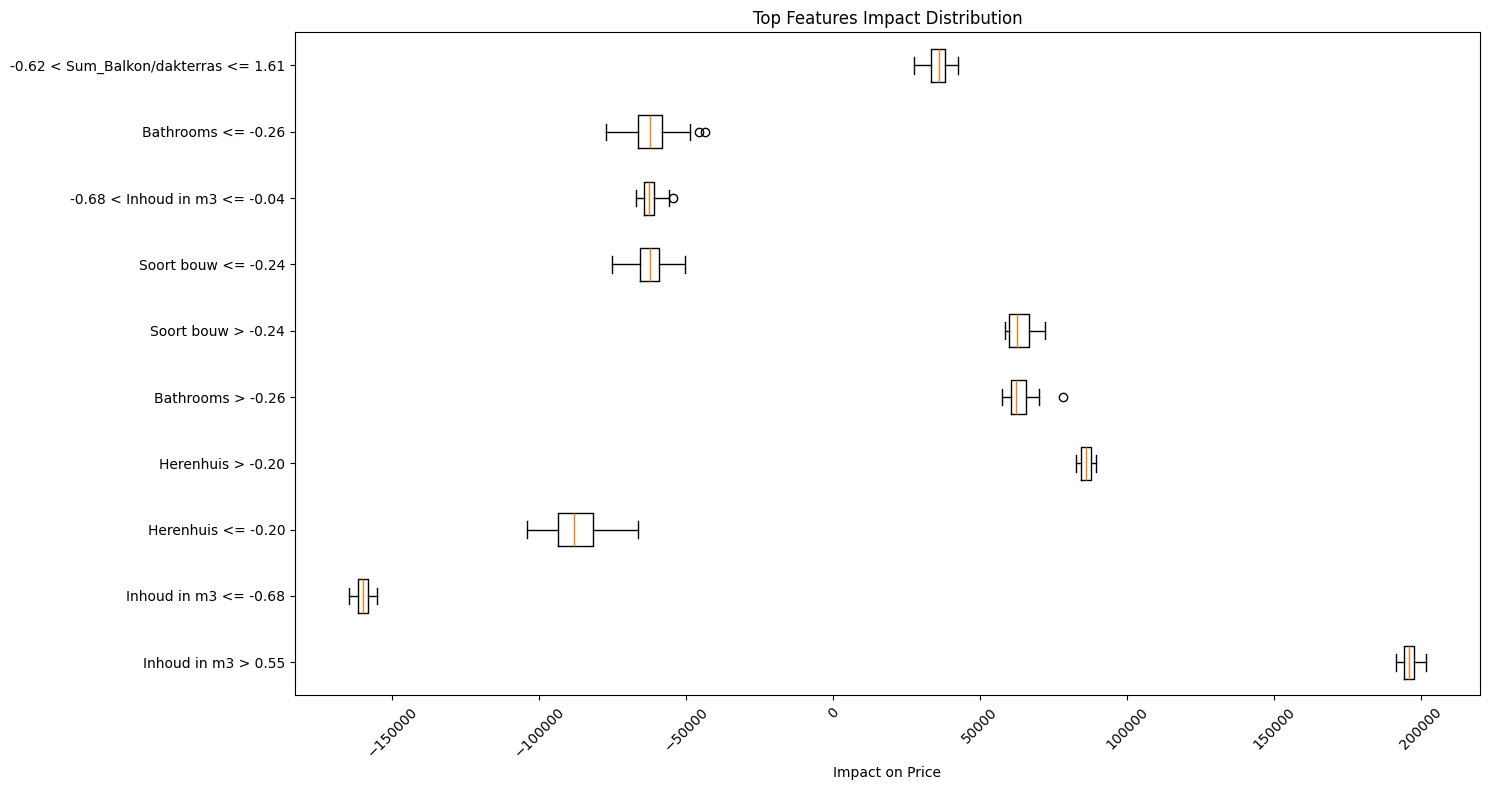

In [21]:
def plot_feature_importance_distribution(valid_X, model, explainer, n_samples=100, top_n=10):
    feature_impacts = {}
    sample_indices = np.random.choice(valid_X.index, min(n_samples, len(valid_X)), replace=False)
    
    for idx in sample_indices:
        instance = valid_X.loc[idx].values
        exp = explainer.explain_instance(
            instance,
            model.predict,
            num_features=len(valid_X.columns)
        )
        
        for feature, impact in exp.as_list():
            if feature not in feature_impacts:
                feature_impacts[feature] = []
            feature_impacts[feature].append(impact)
    
    # Calculate the average impact and select the top features
    mean_impacts = {f: np.mean(impacts) for f, impacts in feature_impacts.items()}
    top_features = sorted(mean_impacts.items(), key=lambda x: abs(x[1]), reverse=True)[:top_n]
    
    # Create a boxplot
    plt.figure(figsize=(15, 8))
    plot_data = []
    labels = []
    
    for feature, _ in top_features:
        plot_data.append(feature_impacts[feature])
        labels.append(feature)
    
    plt.boxplot(plot_data, labels=labels, vert=False)
    plt.title('Top Features Impact Distribution')
    plt.xlabel('Impact on Price')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



print("\n3. Visualize the distribution of the top features impact")
plot_feature_importance_distribution(valid_X, model, explainer)

# LIME Analysis of House Price Prediction Model

## Feature Impact Distribution Analysis

### 1. Volume Impact (Inhoud in m3)
- **Very Small Volume (<= -0.68)**
  - Strong negative impact: > -€100,000
  - Most consistent negative effect
- **Very Large Volume (> 0.55)**
  - Highest positive impact: ~+€150,000
  - Shows significant price premium
- **Medium Volume (-0.68 to -0.04)**
  - Moderate negative impact
  - Shows consistent effect pattern

### 2. Building Type Impact (Soort bouw)
- **Below Reference (<= -0.24)**
  - Negative impact: ~-€50,000
  - Relatively small variance
- **Above Reference (> -0.24)**
  - Positive impact: ~+€100,000
  - High consistency in effect
- **Notable**: Shows clear binary impact pattern

### 3. Bathroom Impact
- **Fewer Bathrooms (<= -0.26)**
  - Negative impact: ~-€50,000
  - Consistent effect
- **More Bathrooms (> -0.26)**
  - Positive impact: ~+€50,000
  - Symmetrical effect pattern

### 4. Mansion Type Impact (Herenhuis)
- **Non-Mansion (<= -0.20)**
  - Moderate negative impact: ~-€25,000
  - Relatively consistent effect
- **Mansion (> -0.20)**
  - Positive impact: ~+€50,000
  - Clear price premium

### 5. Balcony/Roof Terrace Impact (Sum_Balkon/dakterras)
- **Limited/No Balcony (<= -0.62)**
  - Slight negative impact
  - Low variance in effect
- **Notable**: Less influential compared to other features

## Key Insights

1. **Primary Price Drivers**
   - House volume (Inhoud in m3) is the strongest price determinant
   - Building type shows second highest impact
   - Bathroom count demonstrates significant influence

2. **Effect Consistency**
   - Most features show consistent effects (small box sizes)
   - Volume shows highest variance in impact
   - Building type shows very consistent effects

3. **Practical Implications**
   - Volume should be primary consideration in price estimation
   - Building type significantly affects property value
   - Bathroom count offers predictable price impacts


## Neural Network

In [44]:
# Load all names of features into feauture_names

feature_names = df_outlier.columns.tolist()

In [45]:
torch.manual_seed(1234)
np.random.seed(1234)

In [46]:
# Convert to PyTorch tensors
X_train = torch.tensor(train_X.to_numpy()).float()
y_train = torch.tensor(train_y.to_numpy()).float().contiguous().view(-1, 1)

X_test = torch.tensor(test_X.to_numpy()).float()
y_test = torch.tensor(test_y.to_numpy()).float().contiguous().view(-1, 1)

# Create datasets and data loaders
datasets = torch.utils.data.TensorDataset(X_train, y_train)
train_iter = torch.utils.data.DataLoader(datasets, batch_size=10, shuffle=True)

In [47]:
# Improved hyperparameters for better performance
batch_size = 128  # Further increased batch size for faster training
num_epochs = 200  # Increased epochs for better convergence
learning_rate = 0.01  # Reduced learning rate for more stable optimization
size_hidden1 = 256  # Increased size of the first hidden layer for better feature extraction
size_hidden2 = 128  # Increased size of the second hidden layer
size_hidden3 = 64   # Increased size of the third hidden layer
size_hidden4 = 1    # Output layer remains the same
dropout_rate = 0.3  # Dropout rate for regularization

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(30, size_hidden1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        self.lin2 = nn.Linear(size_hidden1, size_hidden2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)
        self.lin3 = nn.Linear(size_hidden2, size_hidden3)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(dropout_rate)
        self.lin4 = nn.Linear(size_hidden3, size_hidden4)

    def forward(self, input):
        x = self.dropout1(self.relu1(self.lin1(input)))
        x = self.dropout2(self.relu2(self.lin2(x)))
        x = self.dropout3(self.relu3(self.lin3(x)))
        return self.lin4(x)

In [48]:
model = Model()
model.train()
criterion = nn.MSELoss(reduction='sum')

In [49]:
def train(model_inp, train_iter, val_iter=None, num_epochs=num_epochs):
    optimizer = torch.optim.RMSprop(model_inp.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
    
    for epoch in range(num_epochs):
        model_inp.train()
        running_loss = 0.0

        for inputs, labels in train_iter:
            outputs = model_inp(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            # Optional: gradient clipping
            nn.utils.clip_grad_norm_(model_inp.parameters(), max_norm=5.0)
            optimizer.step()

            running_loss += loss.item()

        scheduler.step()

        if epoch % 20 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss:.4f}")

            if val_iter:
                model_inp.eval()
                val_loss = 0.0
                with torch.no_grad():
                    for val_inputs, val_labels in val_iter:
                        val_outputs = model_inp(val_inputs)
                        val_loss += criterion(val_outputs, val_labels).item()
                print(f"          Validation Loss: {val_loss:.4f}")


In [50]:
def train_load_save_model(model_obj, model_path, train_iter, val_iter=None):
    if os.path.exists(model_path):
        print('Model already trained. Loading model from path:', model_path)
        model_obj.load_state_dict(torch.load(model_path))
    else:
        # train model
        train(model_obj, train_iter, val_iter)
        print('Finished training the model. Saving the model to the path:', model_path)
        torch.save(model_obj.state_dict(), model_path)


In [51]:
SAVED_MODEL_PATH = 'prediction_model.pt'
train_load_save_model(model, SAVED_MODEL_PATH, train_iter)  # or just train_iter if no val


Epoch [1/200], Train Loss: 126440107687936.0000
Epoch [21/200], Train Loss: 68828601648128.0000
Epoch [41/200], Train Loss: 67255554724864.0000
Epoch [61/200], Train Loss: 61941848151040.0000
Epoch [81/200], Train Loss: 61327524071424.0000
Epoch [101/200], Train Loss: 58698923518976.0000
Epoch [121/200], Train Loss: 57277029388288.0000
Epoch [141/200], Train Loss: 58958219831296.0000
Epoch [161/200], Train Loss: 56683776784384.0000
Epoch [181/200], Train Loss: 57410154303488.0000
Finished training the model. Saving the model to the path: prediction_model.pt


In [52]:
model.eval()
outputs = model(X_test)
err = np.sqrt(mean_squared_error(outputs.detach().numpy(), y_test.detach().numpy()))

print('model err: ', err)

model err:  110587.805


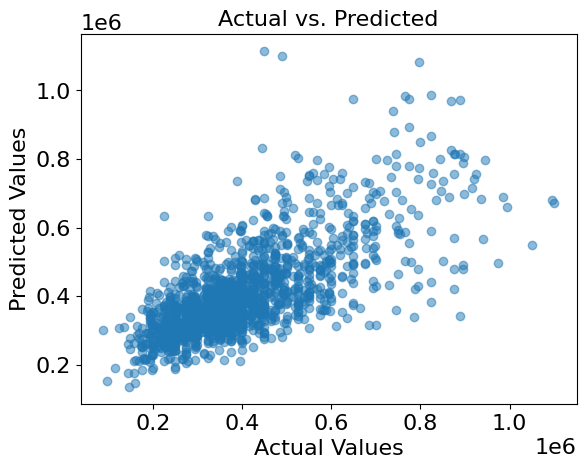

In [53]:
plt.scatter(y_test.detach().numpy(), outputs.detach().numpy(), alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted")
plt.show()

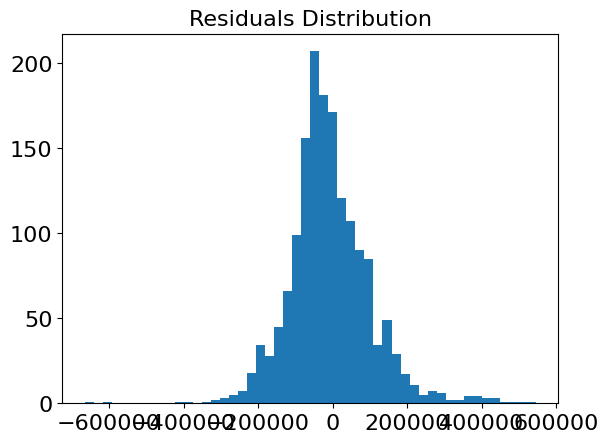

In [54]:
residuals = y_test.detach().numpy() - outputs.detach().numpy()
plt.hist(residuals, bins=50)
plt.title("Residuals Distribution")
plt.show()

In [55]:
# We define different feature attributtion based methods here:
ig = IntegratedGradients(model)
ig_nt = NoiseTunnel(ig)
dl = DeepLift(model)
gs = GradientShap(model)
fa = FeatureAblation(model)

ig_attr_test = ig.attribute(X_test, n_steps=50)
ig_nt_attr_test = ig_nt.attribute(X_test)
dl_attr_test = dl.attribute(X_test)
gs_attr_test = gs.attribute(X_test, X_train)
fa_attr_test = fa.attribute(X_test)

c:\Users\HUAWEI\AppData\Local\Programs\Python\Python312\Lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
c:\Users\HUAWEI\AppData\Local\Programs\Python\Python312\Lib\site-packages\captum\attr\_core\deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(
